# Part I:  Research Question

## A.  Describe the purpose of this data analysis by doing the following:

### 1.  Summarize one research question that you will answer using neural network models and NLP techniques. Be sure the research question is relevant to a real-world organizational situation and sentiment analysis captured in your chosen dataset.

Given the text of a customer review, is it possible to accurately predict the sentiment (good or bad) of that review using a neural network model trained on prior customer reviews?

### 2.  Define the objectives or goals of the data analysis. Be sure the objectives or goals are reasonable within the scope of the research question and are represented in the available data.
This data analysis aims to develop a neural network model that can examine the text of a customer review and assign a score corresponding to good or bad using 0 or 1.

The objectives of this analysis is to examine the provided customer review data, clean it and prepare it for use in a neural network.

To do that, an examination will be done to confirm there are no null values and all entries match their required data type and necessary values, removing any that do not meet that criteria.
Then the data will be prepared for use in a neural network. By inspecting the text values for unusual or unnecessary characters and words, tokenized, sequenced, and padded to match the required type and shape for use in a neural network using Tensor Flow.

This analysis will create a model that can predict customer sentiment based on reviews and score them as good or bad by assigning values of 1 or 0 to them. 

Using the resulting predictive model can aid in various business strategies, such as identifying problem areas that receive more bad reviews so that decision-makers can quickly identify problems and develop solutions around customer satisfaction.



### 3.  Identify a type of neural network capable of performing a text classification task that can be trained to produce useful predictions on text sequences on the selected data set.

For this analysis, a recurrent neural network (RNN) would be best suited for text classification and sentiment analysis.

The model will be developed by creating a Sequential Keras model from Tensor Flow. The implementation of the model will start with an embedding layer followed by a series of dense hidden layers. This structure will allow the model to learn from the formatted text data. Then relationships amidst that data can be calculated, and a final output layer will pass a predicated value for the review sentiment.

In [1469]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC


import re
from collections import Counter
import spacy
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from gensim.models.tfidfmodel import TfidfModel
from nltk.corpus import stopwords
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, LSTM, Dropout, SimpleRNN
from keras.callbacks import History 
from sklearn.model_selection import train_test_split

In [1470]:
amz = pd.read_csv('amazon_cells_labelled.txt', delimiter='\t', header=None, names=['review', 'rating'])
imbd = pd.read_csv('imdb_labelled.txt', delimiter='\t', header=None, names=['review', 'rating'])
yelp =  pd.read_csv('yelp_labelled.txt', delimiter='\t', header=None, names=['review', 'rating'])
df = pd.concat([amz, imbd, yelp])
df.reset_index(inplace=True)

In [1471]:
df.sample(10)

,index,review,rating
1985,237,I'd say that would be the hardest decision... ...,1
1509,509,"The fat computer geek was unbelievable, the bi...",0
2668,920,"Needless to say, I won't be going back anytime...",0
2330,582,"If you look for authentic Thai food, go else w...",0
2487,739,Never had anything to complain about here.,1
1402,402,Perabo has a nice energy level and is obviousl...,1
499,499,WELL IM SATISFIED.,1
1421,421,Don't miss it.,1
2005,257,I as well would've given godfathers zero stars...,0
2075,327,They could serve it with just the vinaigrette ...,1


In [1472]:
df.shape

(2748, 3)

In [1473]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2748 entries, 0 to 2747
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   2748 non-null   int64 
 1   review  2748 non-null   object
 2   rating  2748 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 64.5+ KB


In [1474]:
df.describe()

,index,rating
count,2748.000000,2748.000000
mean,465.203057,0.504367
std,276.612338,0.500072
min,0.000000,0.000000
25%,228.750000,0.000000
50%,457.500000,1.000000
75%,686.250000,1.000000
max,999.000000,1.000000


In [1475]:
df['rating'].value_counts()

1    1386
0    1362
Name: rating, dtype: int64

In [1476]:
df.isna().sum()

index     0
review    0
rating    0
dtype: int64

In [1477]:
df.review.sample(10)

2648                          Spend your money elsewhere.
1703           The movie seemed a little slow at first.  
124                                    Gets the job done.
266                               Returned 8 hours later.
1739               Fans of the genre will be in heaven.  
122                    Iam very pleased with my purchase.
1631                          Trumbull on I LOVE LUCY).  
1042    It was too predictable, even for a chick flick.  
900     This was utterly confusing at first, which cau...
2338                   Great place fo take out or eat in.
Name: review, dtype: object

# Part II:  Data Preparation

## B.  Summarize the data cleaning process by doing the following:

### 1.  Perform exploratory data analysis on the chosen dataset, and include an explanation of each of the following elements:

#### - presence of unusual characters (e.g., emojis, non-English characters, etc.)
This data contains all 26 English letters, all digits 0-9, and 25 special or non-English characters.

#### - vocabulary size
The vocabulary size for this dataset is 4,764 words

#### - proposed word embedding length
The embedding for this model requires two different dimensions, an input dimension of the word embedding length and an output dimension set as the maximum sequence length equal to the vocabulary size (4,764) and an output dimension.

#### - statistical justification for the chosen maximum sequence length
For this model I propose to use the maximum sequence embedding length equal to the 4th root of the vocabulary size, which is 8.

In [1478]:
reviews = df['review']
char_list = []
for review in reviews:
    for word in word_tokenize(review.lower()):
        for char in word:
            if char not in char_list:
                char_list.append(char)

alpha = '[a-zA-Z]'
num = '[0-9]'
alpha_chars = []
num_chars = []
nonal_num_chars = []

for char in char_list:
    try:
        try:
            alpha_chars.append(re.match(alpha, char)[0])
        except:
            num_chars.append(re.match(num, char)[0])    
    except:
        nonal_num_chars.append(char)
        
print('All alpha Characters:')
print(alpha_chars)
print('There are ',len(alpha_chars),' unique english letters in this dataset')
print(' ')

print('All numeric Characters:')
print(num_chars)
print('There are ',len(num_chars),' unique numerical characters in this dataset')
print(' ')
      
print('All non-alphanumeric characters:')
print(nonal_num_chars)
print('There are ',len(nonal_num_chars),' unique special characters in this dataset')

All alpha Characters:
['s', 'o', 't', 'h', 'e', 'r', 'i', 'n', 'w', 'a', 'y', 'f', 'm', 'p', 'l', 'u', 'g', 'b', 'c', 'v', 'd', 'x', 'j', 'z', 'q', 'k']
There are  26  unique english letters in this dataset
 
All numeric Characters:
['4', '5', '7', '3', '6', '8', '0', '2', '1', '9']
There are  10  unique numerical characters in this dataset
 
All non-alphanumeric characters:
['.', ',', '!', '+', '`', "'", '/', '?', '-', ':', ')', '(', '&', '$', '*', ';', '%', '#', '[', ']', '\x96', 'é', 'å', '\x97', 'ê']
There are  25  unique special characters in this dataset


### 2.  Describe the goals of the tokenization process, including any code generated and packages that are used to normalize text during the tokenization process.

The goals of tokenization are to prepare the text in the dataset for input as an array into the neural network by standardizing and formatting the text for uniformity, then creating an array of numerical indexes properly formatted for a neural network.

 First, each review is split into a list of individual words. Those are then transformed into lowercase forms, so capitalization is not a factor in standardizing the text.
 
Next stop words are removed from each tokenized list, so the remaining list contains unique words that convey information and context to the text.

The list is then lemmatized so that variations of a word are all represented the same.

Finally, to prepare the tokenized text for input into the neural network, each word must be converted to a numerical value. To do this, an index number is created for each word in the vocabulary. Those values then replace each word in the list according to its index number.


In [1479]:
rev_list = []
rev_len = []
stop_words = stopwords.words('english')

for review in df.review:
    review = re.sub("[^a-zA-Z\s]", "", review)
    review = review.lower()
    review = nltk.word_tokenize(review)
    review = [word for word in review if not word in stop_words]
    lemma = nltk.WordNetLemmatizer()
    review = [lemma.lemmatize(word) for word in review]
    #review = ''.join(review)
    length = len(review)
    rev_len.append(length)
    rev_list.append(review)

n = random.randint(0, len(rev_list))
rev_list = np.asarray(rev_list, dtype=object)
print(rev_list[n])

['story', 'line', 'awful']


In [1480]:
tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(rev_list)
word_index = tokenizer.word_index
word_counts = list(tokenizer.word_counts.items())
word_counts.sort(key=lambda y: y[1], reverse=True)
vocab_size = len(tokenizer.word_index)+1

max_seq_emb = int(round(vocab_size ** (1/4))) #, 0))
max_len = len(max(rev_list, key=len))

sequence = tokenizer.texts_to_sequences(rev_list)

### 3.  Explain the padding process used to standardize the length of sequences, including the following in your explanation:

#### - if the padding occurs before or after the text sequence

Because each review has varying lengths and word counts, it's essential to pad the result sequence of indexes for those reviews so that they are all the same length.

To do this, 0 values are added to the list until the lengths of all sequences are identical.
For this model, padding will be added at the end of the sequences.

In [1481]:
padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')

In [1482]:
print('Vocabulary size: ',vocab_size)
print('max sequence embed: ', max_seq_emb)
print('max review length: ', max_len)

Vocabulary size:  4764
max sequence embed:  8
max review length:  686


#### - a screenshot of a single padded sequence

In [1483]:
n = random.randint(0, len(rev_list))
print('Original Review:')
print('"', df.review[n], '"')
print('____________________________________________________________')
print('')

print('Review split, lemmatized and stop words removed')
print(rev_list[n])
print('____________________________________________________________')
print('')


print('Review tokenized, sequenced and padded:')
print(padded_sequence[n])

Original Review:
" I was left shattered from the experience of watching this 'film' and I took a good two hours to fully recover.   "
____________________________________________________________

Review split, lemmatized and stop words removed
['left', 'shattered', 'experience', 'watching', 'film', 'took', 'good', 'two', 'hour', 'fully', 'recover']
____________________________________________________________

Review tokenized, sequenced and padded:
[ 254 2811   81  130    4  301    1   63  115 1402 2812    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0

### 4.  Identify how many categories of sentiment will be used and an activation function for the final dense layer of the network.

The ratings for this data set are comprised of binary data, either a 0 for a bad review or a 1 for a good review. This binary result makes binary cross entropy an ideal loss function as it is well suited for binary classification.

The model then needs to output a binary result to compile using that loss function. Therefore, a final Dense layer with an output of 1 is necessary.

Since the output is only 1 unit that needs to be 0 or 1, the ideal activation for this final layer is “sigmoid,” which returns a value between 0 and 1.


### 5.  Explain the steps used to prepare the data for analysis, including the size of the training, validation, and test set split.

To this point, the review data has been tokenized, sequenced, and padded into an array suited for a neural network model.

The dataset will need to be split into a training set and a testing set to train the model.
80% of the data will be retained for training, and the remaining 20% will be used for testing.

Finally, a validation set is needed for model learning. This will be set in the fit method for the model using the “validation_split” call set to .2, or 20% of the data.

This will allow the training data to be shuffled between each epoch so the model can train and validate different arrangements of the dataset on each epoch.

### 6.  Provide a copy of the prepared dataset.

See attached

# Part III:  Network Architecture

## C.  Describe the type of network used by doing the following:

### 1.  Provide the output of the model summary of the function from TensorFlow.

see below

### 2.  Discuss the number of layers, the type of layers, and total number of parameters.

This neural network is built as a sequential model from Keras. It has four layers starting with an embedding layer set to the input dimension equal to the vocabulary size and the output dimension set to the previously calculated maximum sequence embedding length, 8. This layer has a total number of parameters of 38,112.

The next layer is a Global Averager Pool 1D layer.

The following two layers are Dense layers with sigmoid activations.

The first Dense layer of 50 nodes, and the second Dense layer is also the output layer which consists of 1 node.

The total trainable parameters for this model is 38,613


### 3.  Justify the choice of hyperparameters, including the following elements:

#### - activation functions
The two dense layers are the only two that require an activation function. In both cases, a sigmoid function is used since it is an S-shaped curve function that outputs values between 0 and 1, centered on 5, which is ideally suited for the required output of this model.

#### - number of nodes per layer
The input layer is the embedding layer, which requires the number of nodes equal to the vocabulary size.

The Global Average Pool 1D layer does not require a node specification
The next Dense layer uses 50 nodes. This number was determined through trial and error to keep the model simple. Various values were tried between 5 and 200. Any more nodes above 50 did not result in any noticeable improvements in accuracy.

The final layer is the output layer, and as a result of using binary cross entropy for the loss function, an output of only one node is required.

#### - loss function
Binary Cross Entropy was selected as a loss function due to its value in use when predicting binary values that match well to the target values of 0 or 1 based on the ratings in the original dataset

#### - optimizer
The Adam optimizer (adaptive moment estimation) was selected for this model based on its broad appeal as an optimizer in many neural networks. It is an efficient function that adapts well to many data types and shapes with little need for changing parameters.

#### - stopping criteria
The “Early Stopping” callback is used as a stop for the model with a patience setting of 5. A large number of epochs was selected to ensure that the model trains thoroughly on the available dataset.

However, excessive run time and overfitting are a concern with so many epochs, and this stopping criterion was implemented to halt the fitting of the model once improvements have diminished.

Several values were tested for patience from 0 to 100. A value of 5 was suitable as it allowed for sufficient time for the model to train while stopping it before the loss and validation diverged and overfitting occurred.

#### - evaluation metric
Since the goal of this model is to predict a user's rating based on a review, the most important metric is accuracy and was used as an evaluation for training.

In [1484]:
keras.backend.clear_session()

model = keras.Sequential()
model.add(Embedding(vocab_size, max_seq_emb))
model.add(GlobalAveragePooling1D())
model.add(Dense(50, activation="sigmoid"))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss='BinaryCrossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 8)           38112     
                                                                 
 global_average_pooling1d (G  (None, 8)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 50)                450       
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 38,613
Trainable params: 38,613
Non-trainable params: 0
_________________________________________________________________


In [1485]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequence,
                                                    np.array(df.rating),
                                                    test_size=0.2,
                                                    random_state=42)

pd.DataFrame(X_train).to_csv('X_training_data.csv')
pd.DataFrame(X_test).to_csv('X_testing_data.csv')
pd.DataFrame(y_train).to_csv('y_training_data.csv')
pd.DataFrame(y_test).to_csv('y_testing_data.csv')

In [1486]:
print('Size and shape of the training data set:')
print('Training data X values (reviews text) size = ',X_train.size, ' and shape = ', X_train.shape)
print('Training data Y values (review ratings) size = ',y_train.size, ' and shape = ', y_train.shape)

print('')
print('')

print('Size and shape of the training data set:')
print('Training data X values (reviews text) size = ',X_test.size, ' and shape = ', X_test.shape)
print('Training data Y values (review ratings) size = ',y_test.size, ' and shape = ', y_test.shape)

Size and shape of the training data set:
Training data X values (reviews text) size =  1507828  and shape =  (2198, 686)
Training data Y values (review ratings) size =  2198  and shape =  (2198,)


Size and shape of the training data set:
Training data X values (reviews text) size =  377300  and shape =  (550, 686)
Training data Y values (review ratings) size =  550  and shape =  (550,)


## D.  Evaluate the model training process and its relevant outcomes by doing the following:

### 1.  Discuss the impact of using stopping criteria instead of defining the number of epochs, including a screenshot showing the final training epoch.

As mentioned in C3, establishing stopping criteria is a valuable feature of this model as it allows for enough epochs that the model can adequately train and reduce loss and improve accuracy without overdoing it by running past any point of improvement or overfitting.

In the case of this model, 1000 was set as the maximum number of epochs, but based on the stop criteria, the model completed training by epoch 98

### 2.  Provide visualizations of the model’s training process, including a line graph of the loss and chosen evaluation metric.

In [1487]:
stop_monitor = keras.callbacks.EarlyStopping(patience=5)

history = model.fit(X_train, y_train,
                    epochs=1000,
                    validation_split=.2,
                    shuffle=True,
                    verbose=2,
                    callbacks=stop_monitor)

Epoch 1/1000
55/55 - 0s - loss: 0.6979 - accuracy: 0.4960 - val_loss: 0.6933 - val_accuracy: 0.5068 - 411ms/epoch - 7ms/step
Epoch 2/1000
55/55 - 0s - loss: 0.6943 - accuracy: 0.4892 - val_loss: 0.6947 - val_accuracy: 0.5068 - 76ms/epoch - 1ms/step
Epoch 3/1000
55/55 - 0s - loss: 0.6936 - accuracy: 0.5068 - val_loss: 0.6938 - val_accuracy: 0.5068 - 75ms/epoch - 1ms/step
Epoch 4/1000
55/55 - 0s - loss: 0.6930 - accuracy: 0.5119 - val_loss: 0.6934 - val_accuracy: 0.4932 - 76ms/epoch - 1ms/step
Epoch 5/1000
55/55 - 0s - loss: 0.6936 - accuracy: 0.4858 - val_loss: 0.6932 - val_accuracy: 0.5068 - 75ms/epoch - 1ms/step
Epoch 6/1000
55/55 - 0s - loss: 0.6934 - accuracy: 0.5131 - val_loss: 0.6934 - val_accuracy: 0.4932 - 81ms/epoch - 1ms/step
Epoch 7/1000
55/55 - 0s - loss: 0.6938 - accuracy: 0.4994 - val_loss: 0.6936 - val_accuracy: 0.5068 - 84ms/epoch - 2ms/step
Epoch 8/1000
55/55 - 0s - loss: 0.6932 - accuracy: 0.5142 - val_loss: 0.6937 - val_accuracy: 0.5068 - 76ms/epoch - 1ms/step
Epoch 9

Epoch 67/1000
55/55 - 0s - loss: 0.4689 - accuracy: 0.9187 - val_loss: 0.5797 - val_accuracy: 0.7250 - 76ms/epoch - 1ms/step
Epoch 68/1000
55/55 - 0s - loss: 0.4617 - accuracy: 0.9033 - val_loss: 0.5705 - val_accuracy: 0.7636 - 75ms/epoch - 1ms/step
Epoch 69/1000
55/55 - 0s - loss: 0.4469 - accuracy: 0.9204 - val_loss: 0.5621 - val_accuracy: 0.7864 - 75ms/epoch - 1ms/step
Epoch 70/1000
55/55 - 0s - loss: 0.4381 - accuracy: 0.9061 - val_loss: 0.5575 - val_accuracy: 0.7614 - 75ms/epoch - 1ms/step
Epoch 71/1000
55/55 - 0s - loss: 0.4247 - accuracy: 0.9170 - val_loss: 0.5530 - val_accuracy: 0.7841 - 75ms/epoch - 1ms/step
Epoch 72/1000
55/55 - 0s - loss: 0.4143 - accuracy: 0.9249 - val_loss: 0.5491 - val_accuracy: 0.7750 - 75ms/epoch - 1ms/step
Epoch 73/1000
55/55 - 0s - loss: 0.4063 - accuracy: 0.9044 - val_loss: 0.5520 - val_accuracy: 0.7295 - 76ms/epoch - 1ms/step
Epoch 74/1000
55/55 - 0s - loss: 0.3941 - accuracy: 0.9255 - val_loss: 0.5375 - val_accuracy: 0.7795 - 75ms/epoch - 1ms/step


In [1488]:
score = model.evaluate(X_test, y_test, verbose=1)

print('Final Model Loss: ', round(score[0],5))
print('Final Model Accuracy: ', round(score[1]*100, 2),'%')

18/18 [==============================] - 0s 588us/step - loss: 0.4824 - accuracy: 0.7691
Final Model Loss:  0.48243
Final Model Accuracy:  76.91 %


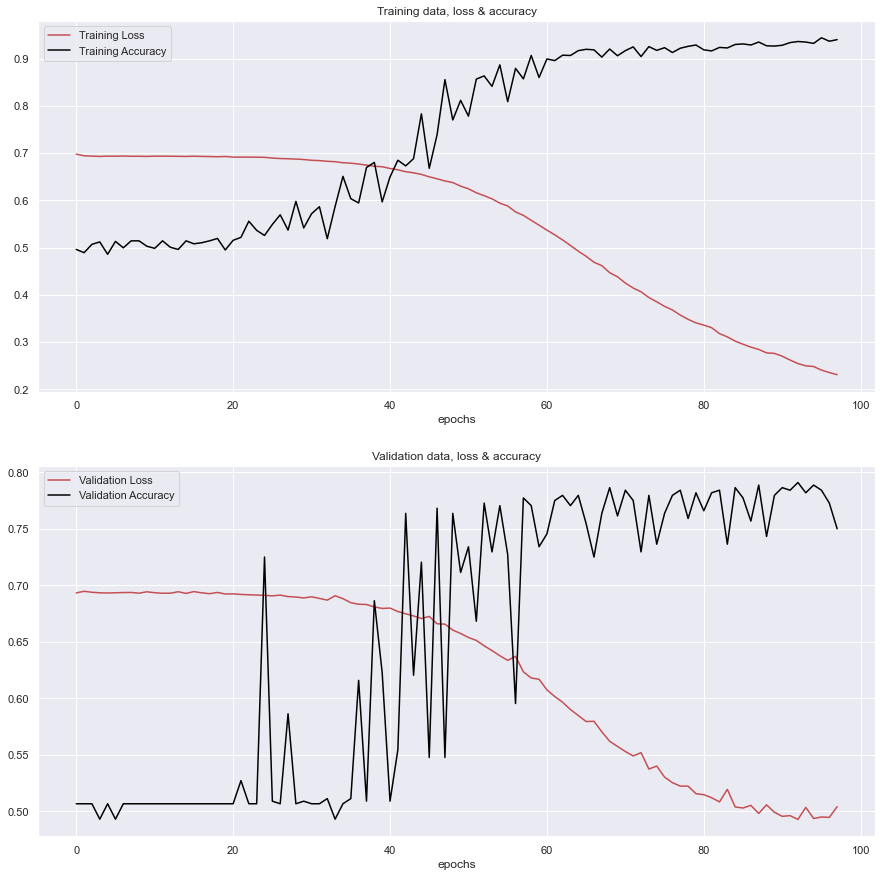

In [1489]:
plt.figure(figsize=(15,15))

plt.subplot(2,1,1)
plt.plot(history.history['loss'], label='Training Loss', c='r')
plt.plot(history.history['accuracy'], label='Training Accuracy', c='black')
plt.xlabel('epochs')
plt.legend()
plt.title('Training data, loss & accuracy')

plt.subplot(2,1,2)
plt.plot(history.history['val_loss'], label='Validation Loss', c='r')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', c='black')
plt.xlabel('epochs')
plt.legend()
plt.title('Validation data, loss & accuracy')

plt.show;

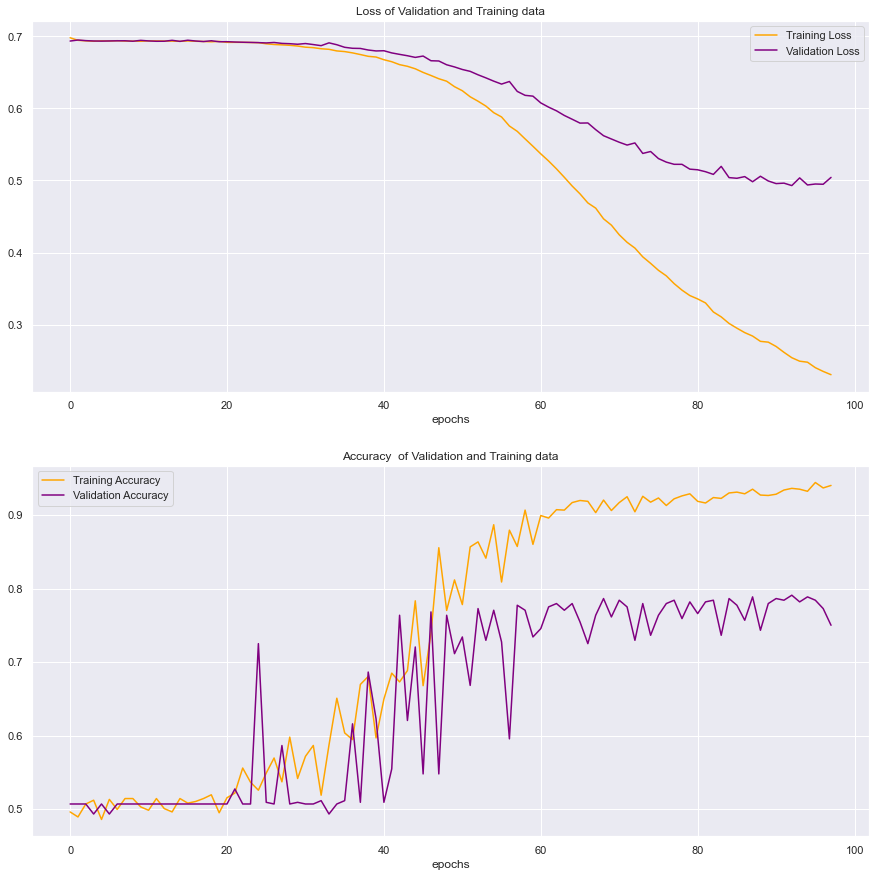

In [1490]:
plt.figure(figsize=(15,15))

plt.subplot(2,1,1)
plt.plot(history.history['loss'], label='Training Loss', c='orange')
plt.plot(history.history['val_loss'], label='Validation Loss', c='purple')

plt.xlabel('epochs')
plt.legend()
plt.title('Loss of Validation and Training data')

plt.subplot(2,1,2)
plt.plot(history.history['accuracy'], label='Training Accuracy', c='orange')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', c='purple')
plt.xlabel('epochs')
plt.legend()
plt.title('Accuracy  of Validation and Training data')

plt.show();

18/18 [==============================] - 0s 559us/step


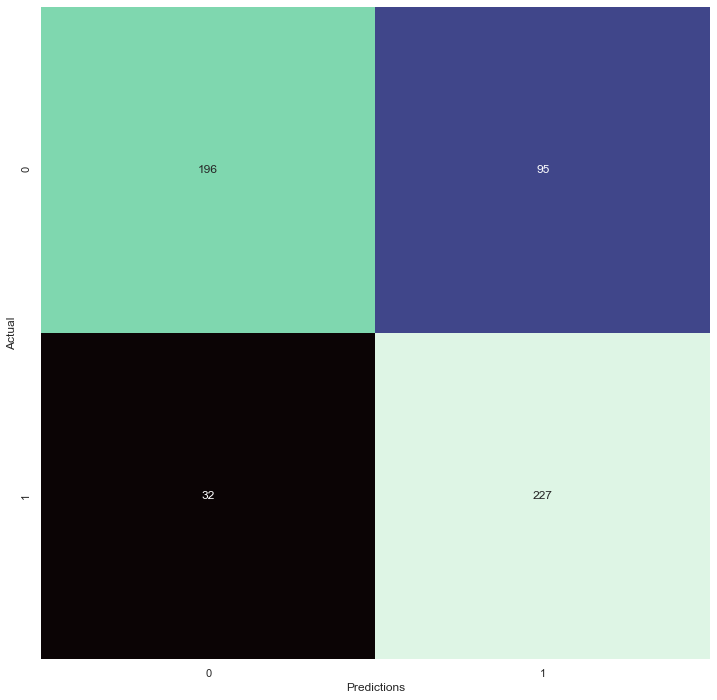

In [1491]:
predictions = model.predict(X_test)
predictions = np.round(predictions,0).astype(int)

con_mat = confusion_matrix(y_test, predictions)
sns.set(rc={'figure.figsize':(12,12)})
sns.heatmap(
    con_mat, annot=True,
    fmt='d', cbar=False,
    cmap='mako').set(
    ylabel='Actual',
    xlabel='Predictions');

### 3.  Assess the fitness of the model and any measures taken to address overfitting.
This model appears to be reasonably fit without any sign of overfitting. A primary measure for avoiding overfitting was using validation data in conjunction with the training data for model fitting. This allowed for examination of validation data alongside each epoch, making any patterns apparent that would provide insight into whether overfitting is occurring.

A key pattern to monitor in this model were trends in the loss values against the validation data loss values. The loss values should continue to drop, but as overfitting begins to occur, the validation data loss values will diverge from the training loss values and begin to increase.

A simple approach was taken to avoid overfitting in this model, adding complexity to the model only as it improved accuracy and did not show indications of overfitting.

Next, a stopping criterion was critical in avoiding overfitting. The model was not permitted to continue to train past a point where improvements could not be made, and overfitting would have been possible.

### 4.  Discuss the predictive accuracy of the trained network.

When used against test data, this model could accurately predict the correct outcome 76.91% of the time. 

For each response option, it correctly predicted a positive review (1) 227 out of 259 times (87.6%), and for negative reviews, it correctly predicted a 0 value 196 out of 291 times (67.4%)

# Part V:  Summary and Recommendations

## E.  Provide the code used to save the trained network within the neural network.


In [1494]:
model.save('D212_Task2_Sent_Analys.h5')

## F.  Discuss the functionality of your neural network, including the impact of the network architecture.

This neural network successfully trained on 2,198 text review and their score labels to create a model that can predict future scores based on text inputs with a 76.91% accuracy according to its predictions of 550 test data observations.

This model can now be used to predict scores of new customer reviews, which can aid in decision-making for business strategies. Since customer satisfaction is a critical consideration in almost all businesses, identifying and addressing problem areas within the company that affects customer satisfaction is vital. This model can assist in identifying areas where predicted scores of customer feedback and reviews can aid in identifying problematic areas based on bad reviews. It can also be used to identify areas of strength for the company that might be good candidates for additional resources or studies to replicate continued success.

The network architecture for this model is well suited for sentiment analysis. An RNN model is ideal for text classification, and the layers were structured with considerations for a binary score output. Optimizers and loss functions provide efficient processing for training while maintaining improvements in key metrics and avoiding overfitting.


## G.  Recommend a course of action based on your results.
Customer satisfaction is a critical component of any business, and this model is well suited to examine customer feedback and review and identify good and bad customer sentiment. A model like this can be valuable in evaluating customer satisfaction metrics.

I recommend that decision-makers utilize this model in analyzing customer feedback to develop reporting and metrics for text-based reviews.


# Part VI: Reporting

## H.  Create your neural network using an industry-relevant interactive development environment (e.g., a Jupyter Notebook). Include a PDF or HTML document of your executed notebook presentation.

See attached

## I.  List the web sources used to acquire data or segments of third-party code to support the application.

Becker, D., Hull, I., & Halder, B. (n.d.). Advanced Data Analytics. DataCamp. Retrieved July 2022, from https://app.datacamp.com/learn/custom-tracks/custom-advanced-data-analytics 

Jarmul, K. (n.d.). Introduction to Natural Language Processing in Python. DataCamp. Retrieved July 2022, from https://app.datacamp.com/learn/courses/introduction-to-natural-language-processing-in-python 

## J.  Acknowledge sources, using in-text citations and references, for content that is quoted, paraphrased, or summarized.

wgu.hosted.panopto. (2022). D213 T2 May 15 22. Retrieved July 2022, from https://wgu.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=cedbd86a-2543-4d9d-9b0e-aec4011a606d. 

Brownlee, J. (2021, February 1). How to use word embedding layers for deep learning with keras. Machine Learning Mastery. Retrieved July 2022, from https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/ 

Team, K. (n.d.). Keras Documentation: Keras API reference. Keras. Retrieved July 2022, from https://keras.io/api/ 

Becker, D., Hull, I., & Halder, B. (n.d.). Advanced Data Analytics. DataCamp. Retrieved July 2022, from https://app.datacamp.com/learn/custom-tracks/custom-advanced-data-analytics 

Jarmul, K. (n.d.). Introduction to Natural Language Processing in Python. DataCamp. Retrieved July 2022, from https://app.datacamp.com/learn/courses/introduction-to-natural-language-processing-in-python 
